In [34]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [66]:
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.download('BTC-USD')
btc_df = btc_df.reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Adj Close', 'Volume', 'Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = df['price-meanavge']/(df['price'] + df['meanavge'])
bins = [-0.43, -0.1, 0, 0.1, 0.43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)
pricefrommean = df.meanvalue.iloc[-1].round(2)
currentzone = df.Valuation.iloc[-1]
delta1cycle = df.index[df['date']=='2015-09-15'].tolist()[0] - df.index[df['date']=='2013-12-04'].tolist()[0]
delta2cycle = df.index[df['date']=='2019-04-2'].tolist()[0] - df.index[df['date']=='2017-12-17'].tolist()[0] 
averageunder = int((delta1cycle+delta2cycle)/2)
delta1fromp2p = df.index[df['date']=='2017-03-17'].tolist()[0] - df.index[df['date']=='2013-12-04'].tolist()[0]
delta2fromp2p = df.index[df['date']=='2020-11-29'].tolist()[0] - df.index[df['date']=='2017-12-17'].tolist()[0] 
averagep2p = int((delta1fromp2p+delta2fromp2p)/2)
sincealltimehigh = df.index[-1] - df.index[df['price']==df.price.max()].tolist()[0]

[*********************100%***********************]  1 of 1 completed


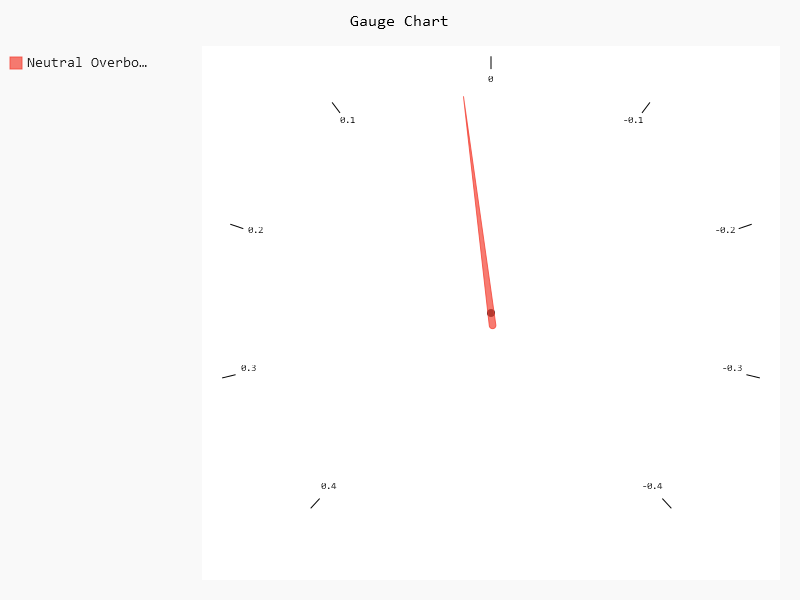

In [74]:
# importing pygal
import pygal

# creating the chart object
gauge = pygal.Gauge()

# naming the title
gauge.title = 'Gauge Chart'	

gauge.range = [-0.43, 0.43]

# Random data
gauge.add(str(df.Valuation.iloc[-1]), df['move%'].iloc[-1])

gauge


In [75]:
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = df.price.iloc[-1],
    mode = "gauge+number+delta",
    title = {'text': "Current Price and ATH Delta"},
    number = {'prefix': "$"},
    delta = {'reference': df.price[df['price']==df.price.max()].tolist()[0], "valueformat": ".0f"},
    gauge = {'axis': {'range': [None, df.price[df['price']==df.price.max()].tolist()[0]]},
    'bar': {'color': "orange"}}))

fig.show()
fig.write_html("../static/priceath.html")

In [71]:
import plotly.graph_objects as go


fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = df.meanavge.iloc[-1],
    mode = "number+delta",
    number = {'prefix': "$"},
    delta = {"reference": ((df.meanavge.iloc[-2])), "valueformat": ".0f"},
    title = {'text': "Meanaverage Day Change"},
    gauge = {'axis': {'range': [None, df.price[df['price']==df.price.max()].tolist()[0]]},
    'bar': {'color': "orange"}}))


fig.show()
fig.write_html("../static/meanaverage.html")

In [38]:
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value =  df.price[df['price']==df.price.max()].tolist()[0],
    mode = "number",
    number = {'prefix': "$"},
    title = {'text': "Previous ATH"},
    gauge = {'axis': {'range': [None, df.price[df['price']==df.price.max()].tolist()[0]]},
    'bar': {'color': "orange"}}))

    

fig.show()
fig.write_html("../static/previousATH.html")

In [73]:
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = df.price.iloc[-1] - df.meanavge.iloc[-1],
    mode = "number+delta",
    number = {'prefix': "$"},
    delta = {"reference": ((df.price.iloc[-2] - df.meanavge.iloc[-2])), "valueformat": ".0f"},
    title = {'text': "Current Price Meanaverage Delta Day Change"},
    gauge = {'axis': {'range': [None, df.price[df['price']==df.price.max()].tolist()[0]]},
    'bar': {'color': "orange"}}))

fig.show()
fig.write_html("../static/price-mean.html")

In [40]:
bitcoin =yf.Ticker('BTC-USD').history(period='ytd',interval='1d',actions=False).reset_index()
bitcoin = ((((bitcoin.Close.iloc[-1]/bitcoin.Close.iloc[0])-1)))

spy500 = yf.Ticker('^GSPC').history(period='ytd',interval='1d',actions=False).reset_index()
spy500 = ((((spy500.Close.iloc[-1]/spy500.Close.iloc[0])-1)))

Gold = yf.Ticker('GC=F').history(period='ytd',interval='1d',actions=False).reset_index()
Gold = ((((Gold.Close.iloc[-1]/Gold.Close.iloc[0])-1)))

nas = yf.Ticker('^IXIC').history(period='ytd',interval='1d',actions=False).reset_index()
nas = ((((nas.Close.iloc[-1]/nas.Close.iloc[0])-1)))

DJ = yf.Ticker('^DJI').history(period='ytd',interval='1d',actions=False).reset_index()
DJ = ((((DJ.Close.iloc[-1]/DJ.Close.iloc[0])-1)))

Oil = yf.Ticker('Cl=F').history(period='ytd',interval='1d',actions=False).reset_index()
Oil = ((((Oil.Close.iloc[-1]/Oil.Close.iloc[0])-1)))

Rus = yf.Ticker('^RUT').history(period='ytd',interval='1d',actions=False).reset_index()
Rus = ((((Rus.Close.iloc[-1]/Rus.Close.iloc[0])-1)))

TLT = yf.Ticker('TLT').history(period='ytd',interval='1d',actions=False).reset_index()
TLT = ((((TLT.Close.iloc[-1]/TLT.Close.iloc[0])-1)))

DXY = yf.Ticker('DX=F').history(period='ytd',interval='1d',actions=False).reset_index()
DXY = ((((DXY.Close.iloc[-1]/DXY.Close.iloc[0])-1)))


data = [["Bitcoin", bitcoin], ["Gold", Gold], ["Oil", Oil],["20yr Treasury", TLT], ["DXY", DXY], ["Russell 2000 Index", Rus], ["S&P 500", spy500], ["NASDAQ", nas], ["Dow Jones", DJ]]

# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Asset', 'YTD%'])
df['YTD%'] = (df['YTD%'].astype(float) * 100).round(2)

In [41]:
import plotly.express as px
fig = px.bar(df, x='YTD%', y='Asset', orientation='h', text=str("YTD%"), color="YTD%",color_continuous_scale=px.colors.sequential.Oryel)
fig.layout.yaxis.tickformat = ',.%'
fig.update_layout(title_text='Year To Date Returns')
fig.update_layout(yaxis=dict(showticklabels=True))

fig.update_layout(
    margin=dict(l=4, r=100, t=70, b=20),
)

fig.write_html("../static/YTD.html")
fig.show()